# Detectors classes

In [1]:
import cv2

class haar_detector():
    def __init__(self):
        self.detector = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_fullbody.xml'
        #     cv2.data.haarcascades + 'haarcascade_upperbody.xml'
        )

    def process(self, frame):
        bodies = self.detector.detectMultiScale(frame, 1.1, 1)
        return bodies
    
class background_subtraction_detector():
    def __init__(self):
        self.detector = cv2.createBackgroundSubtractorMOG2(
            history=150,
            varThreshold=50
        )

    def process(self, frame):
        # Filter image to get people blobs
        mask = self.detector.apply(frame)

        mask[mask>125] = 255
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 7))
        mask = cv2.erode(mask, kernel, iterations=1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)   

        # Consider each blob a person
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bodies = []
        for countour in contours:
            # Calculate area and remove small elements
            area = cv2.contourArea(countour)
            if area > 100:
                x, y, w, h = cv2.boundingRect(countour)
                bodies += [(x, y, w, h)]

        # Reconstruct the colors
#         frame = cv2.bitwise_and(frame, frame, mask=mask)

        return bodies

class yolo_detector():
    def __init__(self):
        
        # Define YOLO files to load
        # weights_file, cfg_file, names_file = "pretrained_yolo/v3/yolov3-tiny.weights", "pretrained_yolo/v3/yolov3-tiny.cfg", "pretrained_yolo/v3/coco.names"
        weights_file, cfg_file, names_file = "pretrained_yolo/v4/yolov4-tiny.weights", "pretrained_yolo/v4/yolov4-tiny.cfg", "pretrained_yolo/v4/coco.names"

        # YOLO and DNN Configs
        # ref: https://docs.opencv.org/4.5.1/d6/d0f/group__dnn.html
        self.mean = (0, 0, 0)  # YOLO doesn't use subtraction.
        self.scale_factor = 1 / (255)  # the colorspace is normalized to match values from 0 to 1, so for 8 bits depth it should be 1/255.
        self.blob_size = tuple([128*2]*2)  # this will impacat on precision over FPS. Smaller means faster. 320x320 is a common value.
        self.confidence_threshold = 0.3  # 0 means no threshold. 0.5 is a common value.
        self.supression_threshold = 0.4  # 1 means no supression. 0.4 is a common value.

        dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_CPU, cv2.dnn.DNN_BACKEND_DEFAULT
        # dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_CPU, cv2.dnn.DNN_BACKEND_OPENCV
        # dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_OPENCL, cv2.dnn.DNN_BACKEND_DEFAULT
        # dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_OPENCL, cv2.dnn.DNN_BACKEND_OPENCV
        # dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_CUDA, cv2.dnn.DNN_BACKEND_CUDA
        # dnn_target, dnn_backend = cv2.dnn.DNN_TARGET_VULKAN, cv2.dnn.DNN_BACKEND_VKCOM

        # Load YOLO
        net = cv2.dnn.readNet(weights_file, cfg_file)
        net.setPreferableBackend(dnn_backend)
        net.setPreferableTarget(dnn_target)

        classes = []
        with open(names_file, "r") as f:
            self.classes = [line.strip() for line in f.readlines()]
            print(f"{len(self.classes)} classes loaded:", end=' ')
            print(classes)
        layer_names = net.getLayerNames()
        # output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        self.output_layers = net.getUnconnectedOutLayersNames()
        self.colors = np.random.uniform(0, 255, size=(len(classes), 3))
        
        self.classes = classes
        self.net = net

    def process(self, frame):
        # Detecting objects
        blob = cv2.dnn.blobFromImage(frame,
            scalefactor=self.scale_factor,
            size=self.blob_size,
            mean=self.mean,
            swapRB=True,
            crop=False,
    #         ddepth=cv2.CV_32F
        )
        self.net.setInput(blob)
        output_blobs = self.net.forward(self.output_layers)

        # Extract bounding boxes for any object detected
        class_ids = []
        confidences = []
        boxes = []
        for output_blob in output_blobs:
            for detection in output_blob:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > self.confidence_threshold:
                    center_x, center_y, w, h = detection[:4] * np.array(
                        [frame_width, frame_height, frame_width, frame_height])
                    x = center_x - (w / 2)
                    y = center_y - (h / 2)
                    boxes.append([int(x), int(y), int(w), int(h)])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Remove coincidental detections
        indices = cv2.dnn.NMSBoxes(
            bboxes=boxes, 
            scores=confidences, 
            score_threshold=self.confidence_threshold, 
            nms_threshold=self.supression_threshold
        )
        
        bodies = []
        # Showing informations on the screen
#         font = cv2.FONT_HERSHEY_SIMPLEX
        for i in range(len(boxes)):
            if i in indices:
                bodies += [boxes[i]]
#                 x, y, w, h = boxes[i]
#                 label = classes[class_ids[i]]
#                 confidence = round(confidences[i]*100)
#                 color = colors[class_ids[i]]
#                 cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
#                 cv2.putText(
#                     frame,
#                     text=f"{label} : {confidence}%",
#                     org=(x, y-5),
#                     fontFace=font,
#                     fontScale=0.3,
#                     color=color,
#                     thickness=1
#                 )

        return bodies

## Getting our ground-truth

In [2]:
import pandas as pd

def setup_ground_truth(ground_truth_filename, crop_window=None,resize='1080p'):
    df = pd.read_csv(
        ground_truth_filename,
        header=None,
        names=['Id', 'Frame', 'Head Valid', 'Body Valid',
               'Head Left', 'Head Top', 'Head Right', 'Head Bottom',
               'Body Left', 'Body Top', 'Body Right', 'Body Bottom'],
    )
    df['Index'] = df.index
    df.set_index(['Index', 'Frame', 'Id'], inplace=True)
    
    # Selecting only the Full Body
    df.drop(columns=[
        'Head Valid',
        'Head Left',
        'Head Top',
        'Head Right',
        'Head Bottom'
    ], inplace=True)
    df.rename(columns={
        'Body Valid': 'Valid',
        'Body Left': 'Left',
        'Body Top': 'Bottom',  # top-bottom reverse
        'Body Right': 'Right',
        'Body Bottom': 'Top'   # top-bottom reverse
    }, inplace=True)

    # Drop all non-valid rows
    df = df[df['Valid'] == 1]
    df.drop(columns=['Valid'], inplace=True)
    df.dropna(inplace=True)

    # Crop
    width, height = 1920, 1080
    if crop_window != None:
        if len(crop_window) != 4:
            print("Wrong format! Expected a tuple like \'crop_window = (left, bottom, right, top)\'.")
            raise
        left, bottom, right, top = crop_window  
        width, height = right - left, top - bottom
        
        # Drop if completely outide of the window
        df = df[~(
            (df['Right'] < left) |
            (df['Bottom'] > top) |
            (df['Left'] > right) |
            (df['Top'] < bottom)
        )]
        
        # Offset
        df['Left'] -= left
        df['Top'] -= bottom
        df['Right'] -= left
        df['Bottom'] -= bottom

    # Resize
    if resize == '1080p':
        k_width, k_height = 1080 / width, 1920 / height
    elif resize == '720p':
        k_width, k_height = 1280 / width, 720 / height
    elif resize == '480p':
        k_width, k_height = 854 / width, 480 / height
    elif resize == '360p':
        k_width, k_height = 640 / width, 360 / height
    
    df['Left'] *= k_width
    df['Right'] *= k_width
    df['Top'] *= k_height
    df['Bottom'] *= k_height
    
    return df.astype(int)

width, height = 845, 480
left, bottom = 600, 300
right, top = left + width, bottom + height
df_gt = setup_ground_truth('TownCentre-groundtruth.top', crop_window=(left, bottom, right, top), resize='360p')
display(df_gt)

,,,Left,Bottom,Right,Top
Index,Frame,Id,,,,
3,0,3,90,-59,141,81
4,0,4,146,-48,198,95
5,0,5,209,69,269,246
17,1,3,92,-61,143,78
18,1,4,149,-49,200,94
...,...,...,...,...,...,...
47724,3087,151,40,-110,86,14
47731,3088,150,310,-82,356,52
47732,3088,151,41,-112,88,13


# Functions to process the video

In [3]:
import numpy as np
import time
green = (0, 255, 0)
red = (0, 0 ,255)

def setup_input(input_filename):
    vcap = cv2.VideoCapture(input_filename)
    
    # Get video properties
    frame_width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = vcap.get(cv2.CAP_PROP_FPS)
    n_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print("Frame width:", frame_width)
    print("Frame width:", frame_height)
    print("Video fps:", fps)

    return vcap, frame_width, frame_height, fps, n_frames

def setup_output(output_filename, frame_width, frame_height, fps):
    apiPreference = cv2.CAP_FFMPEG
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vout = cv2.VideoWriter(
        filename=output_filename,
        apiPreference=apiPreference,
        fourcc=fourcc,
        fps=fps,
        frameSize=(frame_width, frame_height),
        params=[]
    )
    return vout

def process_frames(vcap, vout, df_gt, detector, frames_to_process=100):
    # Start app
    window_name = "People Detecting"
    cv2.startWindowThread()
    cv2.namedWindow(window_name)

    # Loop each frame
    frame_count = 0
    processed_frames = np.zeros(frames_to_process, dtype=object)
    output_data = [] #Index, Frame, Id, Left, Bottom, Right, Top
     
    # start timer
    start = time.time()
    fps_timer = [0, cv2.getTickCount()]
    while vcap.isOpened():
        # Read a frame
        ret, frame = vcap.read()
        if not ret or frame_count == frames_to_process:
            break

        # Apply the body classifier
        bodies = detector.process(frame)
        
        # Draw the bounding boxes for any bodies identified
        # and add detected bounding box to output data
        id_count = 0
        for (left, bottom, w, h) in bodies:
            right, top = left + w, bottom + h
            cv2.rectangle(frame, (left, bottom), (right, top), green, 2)
            index = frame_count+id_count
            output_data += [[index, frame_count, id_count, left, bottom, right, top]]
            id_count += 1
        
        # Get the ground-truth
        bodies_gt = df_gt.loc[(slice(None), frame_count, slice(None)), :].to_numpy().astype(int)

        # Draw the bounding boxes for ground-truth
        for (left, top, right, bottom) in bodies_gt:
            cv2.rectangle(frame, (left, bottom), (right, top), red, 1)

        # Compute and put FPS on frame
        fps = cv2.getTickFrequency() / (fps_timer[1] - fps_timer[0]);
        fps_timer[0] = fps_timer[1]
        fps_timer[1] = cv2.getTickCount()
        cv2.putText(frame,
            text=f"FPS: {int(fps)}",
            org=(frame_width -60, frame_height -5),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            color=green,
            thickness=1
        );

        # Save frame
        processed_frames[frame_count] = frame
        frame_count += 1

        # Show in app
        cv2.imshow(window_name, frame)
        cv2.waitKey(1)

    # end timer
    end = time.time()
    overall_elapsed_time = end - start
    elapsed_time_per_frame = overall_elapsed_time / frame_count

    print("Done!")
    print(f"{frame_count} frames processed in {overall_elapsed_time} seconds.")
    print(f"({elapsed_time_per_frame}) seconds per frame.")
    print(f"({1/elapsed_time_per_frame}) frames per second.")

    # Write processed frames to file
    for frame in processed_frames:
        vout.write(frame)

#     print(f"Output saved to \"{output_filename}\".")

    cv2.destroyAllWindows()
    
    df_out = pd.DataFrame(output_data, columns=['Index', 'Frame', 'Id', 'Left', 'Bottom', 'Right', 'Top'])
#     df_out['Index'] = df_out.index
    df_out.set_index(['Index', 'Frame', 'Id'], inplace=True)
    
    return df_out

# Functions to compute accuracy

In [4]:
from math import factorial
import multiprocessing
import itertools

def compute_bb_area(bb):
    """ bb: [left, bottom, right, top] 
        return: bounding box area """
    left, bottom, right, top = 0, 1, 2, 3
    width = bb[right] - bb[left]
    height = bb[bottom] - bb[top]
    return abs(width * height)

def compute_iou(bb1, bb2):
    """ bb1 and bb2: [left, bottom, right, top]
        return: intersection over area (iou) 
        reference: http://jsfiddle.net/Lqh3mjr5/ """   
    left, bottom, right, top = 0, 1, 2, 3
    
    # Intersection Bouding Box
    bbi = [max(bb1[left], bb2[left]),      # left
           max(bb1[bottom], bb2[bottom]),  # bottom
           min(bb1[right], bb2[right]),    # right
           min(bb1[top], bb2[top])]        # top
    
    # Compute the bounding boxes areas
    bbi_area = compute_bb_area(bbi)
    bb1_area = compute_bb_area(bb1)
    bb2_area = compute_bb_area(bb2)
    bbu_area = bb1_area + bb2_area - bbi_area
    
    iou = bbi_area / bbu_area
    
#     print('\t', bb1, bb2, bbi, bb1_area, bb2_area, bbi_area, bbu_area, iou)
    
    # Return the intersection area over union area
    return iou

def compute_permutation_size(n, r):
    return int(factorial(n) / factorial(n -r))

def chunker(iterator, size):
    iterator = iter(iterator)
    while chunk := list(itertools.islice(iterator, size)):
        yield chunk

def parallel_process(f, data):
    global cpu_threads
    pool = multiprocessing.Pool(cpu_threads)
    for result in pool.imap_unordered(f, data):
        yield result
    pool.close()
    pool.join()

def func_chunk(chunk):
    global A, B, lenA, lenB
    
    local_costs = []
    for combs in chunk:
        for a, b in zip(A[list(combs)], B):
            local_costs += [compute_iou(a, b)]
    
    local_costs = np.array(local_costs).reshape((-1, lenB))
    total_cost = local_costs.sum(axis=1)
    index = total_cost.argmax()
    return chunk[index], total_cost[index]
    
def optimize():
    global permutations, chunksize, A, B, lenA, lenB
    
    results = {'costs': [], 'combs': []}
    
    chunks = chunker(permutations, chunksize)
    for result in parallel_process(func_chunk, chunks):
        comb, cost = result
        results['costs'] += [cost]
        results['combs'] += [comb]

    if len(results['costs']) > 0:
        index = results['costs'].index(max(results['costs']))
        results['costs'] = results['costs'][index]
        results['combs'] = results['combs'][index]
    
    return results

def check_frame_in_df(frame, df):
    for v in df.index.values:
        if v[1] == frame:
            return True
    return False

def compute_accuracy(df_gt, df_out, frames_to_process=100, verbose=False):
    global permutations, chunksize, cpu_threads, total_threads, A, B, lenA, lenB
    
    accuracy_values = []
    for frame in range(frames_to_process):
        if verbose: print('frame:', frame)

        n_bboxes = df_gt.loc[(slice(None), frame, slice(None)), :].index.size
        if verbose: print('ground-truth ids:', n_bboxes)

        # Skip current frame if there is no data for it
        if not check_frame_in_df(frame, df_gt) or not check_frame_in_df(frame, df_out):
            accuracy_values += [[frame, 0]]
            if verbose: print(f'warning: frame {frame} was skipped.')
            continue
        # A, B / lenA needs to be greater than lenB.
        A = df_gt.loc[(slice(None), frame, slice(None)), :].to_numpy()
        B = df_out.loc[(slice(None), frame, slice(None)), :].to_numpy()
        lenA, lenB = len(A), len(B)
        if (lenB > lenA):
            A, B = B, A
            lenA, lenB = lenB, lenA
        if verbose: print('len A:', lenA, 'len B:', lenB)

        maximum_allowed_permutation_size = 3628800  # for sake of my ram
        permutations_size = compute_permutation_size(lenA, lenB)
        if verbose: print("Permutations size:", permutations_size)
        if (permutations_size <= maximum_allowed_permutation_size):
            cpu_threads = min(permutations_size, multiprocessing.cpu_count())
            if verbose: print("CPU Threads:", cpu_threads)

            chunksize = max(1, permutations_size // cpu_threads)
            if verbose: print("Chunk size:", chunksize)

            total_threads = max(cpu_threads, chunksize // cpu_threads)
            if verbose: print("Total Threads:", total_threads)

            elapsed_time = -time.time()
            permutations = itertools.permutations(range(lenA), lenB)
            results = optimize()
            elapsed_time += time.time()

            if verbose: print("Elapsed Time:", elapsed_time, 's')
            if verbose: print("Results:\n", results)
                
            accuracy_values += [[frame, results['costs']]]
        else:
            if verbose: print("Ignoring: permutation size greater than allowed.")
            pass
        if verbose: print('-' * 80)
    
    accuracy_values = np.array(accuracy_values)
    if len(accuracy_values) == 0:
        return np.array([0, 0])
#     total_average_accuracy = accuracy_values[:,1].sum() / frames_to_process
    return accuracy_values


########################################################### testing
width, height = 845, 480
left, bottom = 600, 300
right, top = left + width, bottom + height
df_gt = setup_ground_truth('TownCentre-groundtruth.top', crop_window=(left, bottom, right, top), resize='360p')
df_out = df_gt.copy()

compute_accuracy(df_gt, df_out, frames_to_process=10)

array([[0., 3.],
       [1., 3.],
       [2., 3.],
       [3., 3.],
       [4., 3.],
       [5., 3.],
       [6., 3.],
       [7., 3.],
       [8., 3.],
       [9., 3.]])

# Comparing each detector

In [18]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Get the groud-truth data
width, height = 845, 480
left, bottom = 600, 300
right, top = left + width, bottom + height
df_gt = setup_ground_truth('TownCentre-groundtruth.top', crop_window=(left, bottom, right, top), resize='360p')

detectors = [
    {
        'Name': 'Haar Cascade',
        'Class': haar_detector,
    },
    {
        'Name': 'Backgroun Subtraction',
        'Class': background_subtraction_detector,
    },
    {
        'Name': 'YOLOv4',
        'Class': yolo_detector,
    },
]
frames_to_process = 600

for i in range(len(detectors)):
    print(detectors[i]['Name'])
    # Setup the input video
    vcap, frame_width, frame_height, fps, n_frames = setup_input('./360p_TownCentreXVID.mp4')

    # Setup the output video
    vout = setup_output('./output.mp4', frame_width, frame_height, fps)

    # Process the detector and save the output file
    df_out = process_frames(vcap, vout, df_gt, detector=detectors[i]['Class'](), frames_to_process=frames_to_process)

    # # Release
    vcap.release()
    vout.release()

    detector_accuracy = compute_accuracy(df_gt, df_out)
    detectors[i]['Accuracy Average'] = np.average(detector_accuracy[:,1])
    detectors[i]['Accuracy Median'] = np.median(detector_accuracy[:,1])
    detectors[i]['Accuracy Std'] = np.std(detector_accuracy[:,1])
    detectors[i]['Accuracy Var'] = np.var(detector_accuracy[:,1])
    
    print('Average:', detectors[i]['Accuracy Average'])
    print('Median:', detectors[i]['Accuracy Median'])
    print('Std:', detectors[i]['Accuracy Std'])
    print('Var:', detectors[i]['Accuracy Var'])
    
    print('\n' + '-' * 80)

Haar Cascade
Frame width: 640
Frame width: 360
Video fps: 25.0
Done!
600 frames processed in 11.248070478439331 seconds.
(0.01874678413073222) seconds per frame.
(53.34248226396692) frames per second.
Average: 0.058364201292905676
Median: 0.0
Std: 0.18229374830167264
Var: 0.03323101066987357

--------------------------------------------------------------------------------
Backgroun Subtraction
Frame width: 640
Frame width: 360
Video fps: 25.0
Done!
600 frames processed in 4.84501838684082 seconds.
(0.0080750306447347) seconds per frame.
(123.83853931898662) frames per second.
Average: 3.316601076548535
Median: 1.0156270233652454
Std: 5.716630367658067
Var: 32.6798627604304

--------------------------------------------------------------------------------
YOLOv4
Frame width: 640
Frame width: 360
Video fps: 25.0
80 classes loaded: []
Done!
600 frames processed in 10.357662439346313 seconds.
(0.017262770732243856) seconds per frame.
(57.92812842796862) frames per second.
Average: 4.9883778

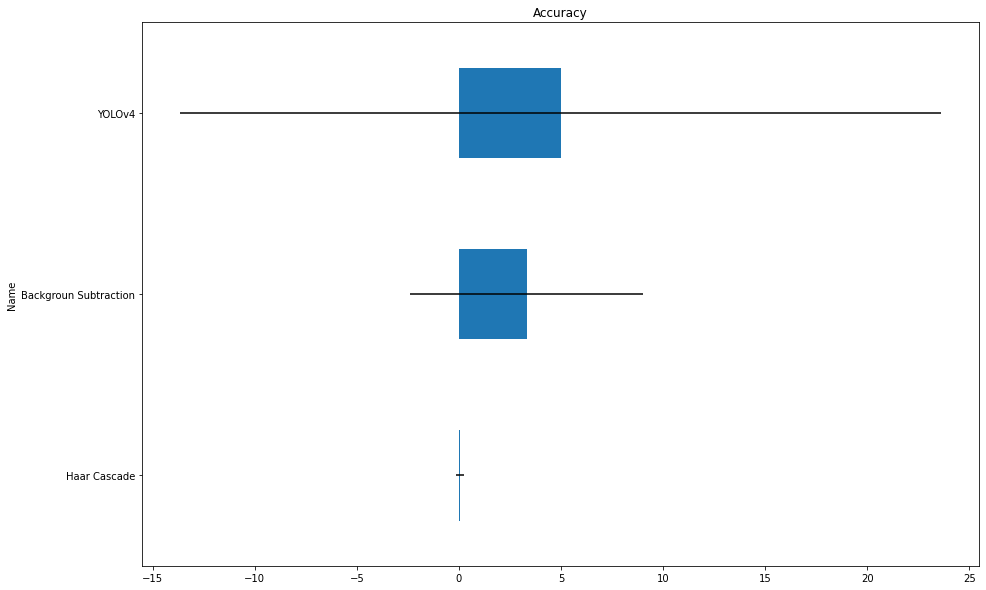

In [41]:
df = pd.DataFrame(detectors)
df.plot(kind = "barh", x="Name", y="Accuracy Average", legend=False,
            title="Accuracy", xerr="Accuracy Std", figsize=(15,10));